In [9]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df = pd.read_csv('../data/clean/dataset_3.csv')

display(df.head())

/var/folders/t_/k5bhrc1x419crrfg_t8zp5nm0000gp/T/ipykernel_3758/3998911535.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/clean/dataset_3.csv')


,date,day_of_week,month,channelGrouping,fullVisitorId,visitNumber,visitStartTime,device_deviceCategory,geoNetwork_continent,geoNetwork_country,...,totals_pageviews,totals_bounces,totals_timeOnSite,totals_transactions,totals_transactionRevenue,trafficSource_campaign,trafficSource_source,trafficSource_medium,trafficSource_isTrueDirect,log_transactionRevenue
0,2017-10-16,0,10,Organic Search,3162355547410993243,1,2017-10-17 00:00:50,desktop,Europe,Germany,...,1,1,0,0,0,(not set),google,organic,True,0.0
1,2017-10-16,0,10,Referral,8934116514970143966,6,2017-10-16 17:51:47,desktop,Americas,United States,...,2,0,28,0,0,(not set),sites.google.com,referral,True,0.0
2,2017-10-16,0,10,Direct,7992466427990357681,1,2017-10-17 00:53:33,mobile,Americas,United States,...,2,0,38,0,0,(not set),(direct),(none),True,0.0
3,2017-10-16,0,10,Organic Search,9075655783635761930,1,2017-10-16 16:04:11,desktop,Asia,Turkey,...,2,0,1,0,0,(not set),google,organic,True,0.0
4,2017-10-16,0,10,Organic Search,6960673291025684308,1,2017-10-16 21:49:12,desktop,Americas,Mexico,...,2,0,52,0,0,(not set),google,organic,True,0.0


# Feature Engineering

## Correlation matrix for numerical columns

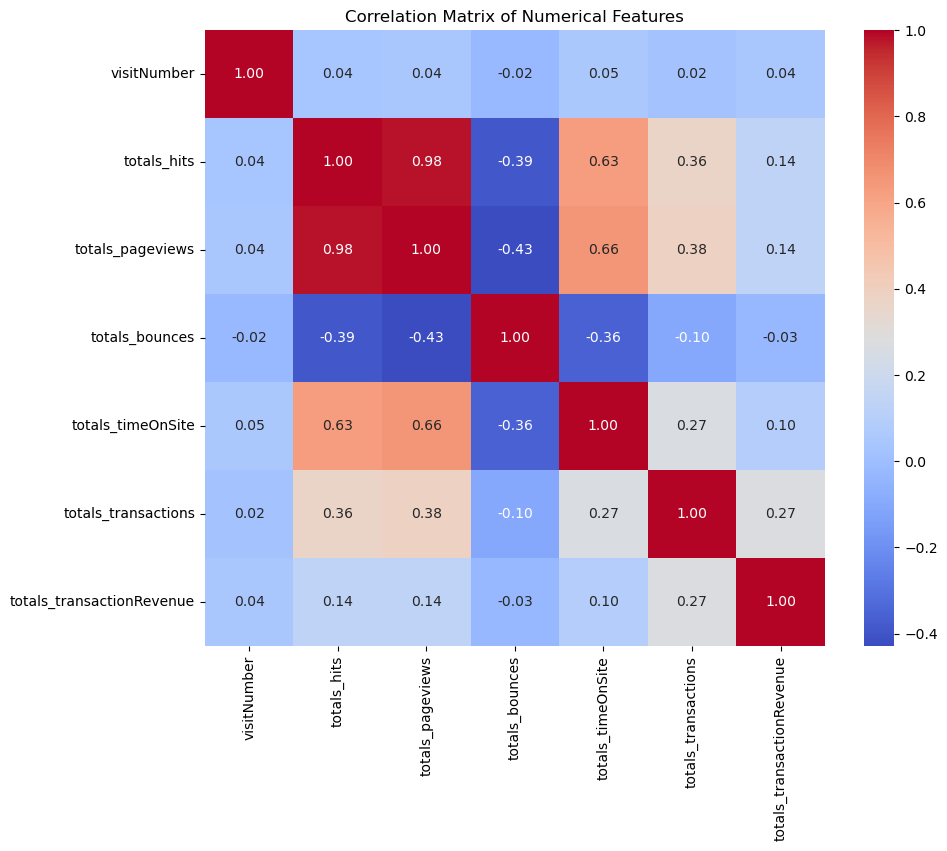

In [19]:
# Filter for only numeric columns
numeric_df = df[['visitNumber', 'totals_hits', 'totals_pageviews', 'totals_bounces', 'totals_timeOnSite', 
              'totals_transactions', 'totals_transactionRevenue']]

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")

plt.title("Correlation Matrix of Numerical Features")

plt.show()